In order to determine what, if any impact population has on bus stop ridership, we first need a measure of population for each stop. In order to calculate population by bus stop we'll use a 400m circular buffer for each stop and sum the populations of the Dissemination Area representative points that fall within that buffer.

First we load a few basic libraries for working wiith spatial data.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

Next we load the BC Dissemination Block attributes and create point geometries from their representative points. The geometries are projected from Stats Canada Lambert (EPSG:3347) to BC Albers (EPSG:3005).

In [2]:
pop_data = pd.read_csv('./Data/DB_attr/BC_DB_attr.csv')
pop_data['geometry'] = [Point(db[9],db[10]) for db in pop_data.itertuples()]

sp_pop_data = gpd.GeoDataFrame(pop_data)
sp_pop_data.crs = {'init' :'epsg:3347'}
sp_pop_data = sp_pop_data.to_crs({'init': 'epsg:3005'})

Then we load the bus stop locations and create point geometries from their lat long pairs. The geometries are projected from WGS 84 (EPSG:4326) to BC Albers (EPSG:3005).

In [3]:
stop_data = pd.read_csv('./Data/StopLocations/stops.txt')
stop_data['geometry'] = [Point(stop[4],stop[3]) for stop in stop_data.itertuples()]

sp_stop_data = gpd.GeoDataFrame(stop_data)
sp_stop_data.crs = {'init': 'epsg:4326'}
sp_stop_data = sp_stop_data.to_crs({'init' :'epsg:3005'})

Now we can create a 400m buffer of each one the stop locations and do a  spatial join to determine the population within 400m of the stop.

In [11]:
buffered_stops = sp_stop_data
buffered_stops.geometry = buffered_stops.geometry.buffer(400)
stops_with_pop = gpd.sjoin(buffered_stops,sp_pop_data, how='left')
pop_by_stopid = stops_with_pop.groupby('stop_id').sum()[' DBpop2016/IDpop2016']
stop_data = stop_data.join(pop_by_stopid, on='stop_id')
stop_data['population'] = stop_data[' DBpop2016/IDpop2016']

Now we can do some quick exploration on the dataset.

count     2322.000000
mean      4021.919466
std       3112.282936
min          0.000000
25%       1721.000000
50%       3399.000000
75%       5614.000000
max      16294.000000
Name: population, dtype: float64


(0, 19249.173773555933)

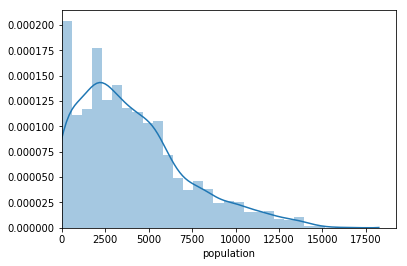

In [29]:
print(stop_data.population.describe())
hist = sns.distplot(stop_data.population)
hist.set_xlim(left=0)

Top Five (by population)

In [30]:
stop_data.sort_values('population', ascending=False).head(10)[['stop_id','stop_name','population']]

,stop_id,stop_name,population
118,100127,Westbound Yates at Cook,16294.0
98,100106,Westbound Yates at Vancouver,15034.0
119,100128,Northbound Cook at Fort,15018.0
116,100125,Eastbound Johnson at Vancouver,14422.0
117,100126,Eastbound Fort at Cook,14358.0
61,100064,Eastbound Fort at Quadra,14289.0
120,100129,Westbound Pandora at Quadra,13949.0
93,100101,Southbound Quadra at Pandora,13949.0
109,100118,Northbound Quadra at Mason,13929.0
150,100160,Northbound Cook at Balmoral,13924.0


Stops with zero population catchement

In [25]:
stop_data.loc[stop_data.population==0]

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,geometry,DBpop2016/IDpop2016,population
147,100157,Swartz Bay Passenger Loop,48.688001,-123.412148,100157,0,NaN,POINT (-123.412147587587 48.6880014248094),0.0,0.0
1331,101386,VI Technology Park Main Entrance,48.493861,-123.409899,101386,0,NaN,POINT (-123.409898999727 48.4938609953017),0.0,0.0
1336,101391,Eastbound 4470 block Markham,48.494184,-123.411748,101391,0,NaN,POINT (-123.411747999414 48.4941839955922),0.0,0.0
1340,101395,Westbound 4470 block Markham,48.494375,-123.411737,101395,0,NaN,POINT (-123.411736999474 48.4943749956045),0.0,0.0
1379,101434,Southbound Interurban at Conway,48.493481,-123.419639,101434,0,NaN,POINT (-123.419638999861 48.4934809952598),0.0,0.0
1380,101435,Northbound Interurban at Conway,48.493572,-123.419440,101435,0,NaN,POINT (-123.419440000467 48.4935719954445),0.0,0.0
1394,101449,Eastbound Markham at Parking Lot 3,48.492963,-123.414232,101449,0,NaN,POINT (-123.414232000113 48.4929629955092),0.0,0.0
1396,101451,Northbound Metchosin at Farhill,48.400354,-123.490020,101451,0,NaN,POINT (-123.490019999716 48.4003539953378),0.0,0.0
1400,101455,Westbound Metchosin at Farhill,48.400087,-123.490680,101455,0,NaN,POINT (-123.490679999643 48.4000869956411),0.0,0.0
1404,101459,Westbound Markham at Parking Lot 3,48.493011,-123.414674,101459,0,NaN,POINT (-123.414673999585 48.4930109958983),0.0,0.0


While quick and easy we can obviously we see that there are several issues with using Dissemination Area representative points. 
1. There are way too many stops with zero population.
2. Areas with high volumes of foot traffic are not represented such as the Downtown Core and the University.
3. Daytime populations and night time populations can be significantly different and Census data typically trends towards night time populations.